In [3]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")
plt.ion()

In [14]:
landmarks_frame = pd.read_csv('./data/faces/face_landmarks.csv')
print("CSV file has following shape:", ' '.join(map(str, landmarks_frame.shape)))
print(landmarks_frame.head())

CSV file has following shape: 69 137
                  image_name  part_0_x  part_0_y  part_1_x  part_1_y  \
0        0805personali01.jpg        27        83        27        98   
1  1084239450_e76e00b7e7.jpg        70       236        71       257   
2         10comm-decarlo.jpg        66       114        65       128   
3   110276240_bec305da91.jpg        42       140        45       161   
4             1198_0_861.jpg       138       392       141       427   

   part_2_x  part_2_y  part_3_x  part_3_y  part_4_x    ...      part_63_x  \
0        29       113        33       127        39    ...             93   
1        75       278        82       299        90    ...            148   
2        67       142        68       156        72    ...            128   
3        51       180        61       200        73    ...            144   
4       145       464       152       501       166    ...            293   

   part_63_y  part_64_x  part_64_y  part_65_x  part_65_y  part_66_x

In [19]:
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n,1:].as_matrix()
landmarks = landmarks.astype(np.float32).reshape(-1, 2)

In [22]:
print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


In [31]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)

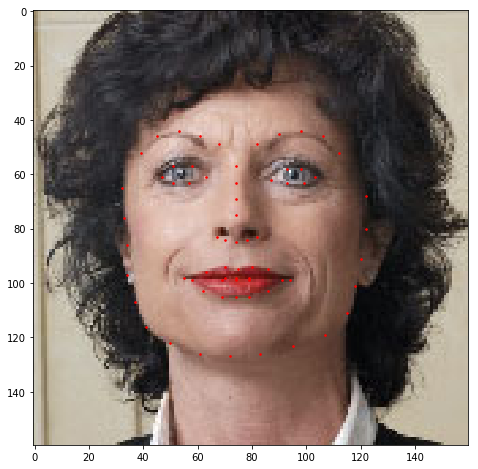

In [32]:
plt.figure(figsize=(8,8))
img = io.imread(os.path.join('./data/faces/', img_name))
show_landmarks(img, landmarks)
plt.show()

In [29]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir 
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype(np.float32).reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample        

In [30]:
face_dataset = FaceLandmarksDataset(csv_file='./data/faces/face_landmarks.csv',
                                   root_dir='./data/faces/')

In [52]:
class Rescale:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w/h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]
        
        return {'image': img, 'landmarks': landmarks}

In [57]:
resize = transforms.Compose([Rescale(1024)])

0 (1543, 1024, 3) (68, 2)


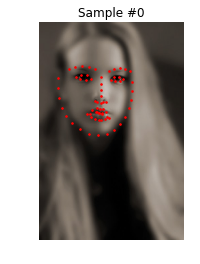

1 (1537, 1024, 3) (68, 2)


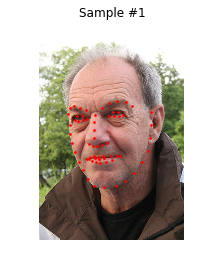

2 (1024, 1056, 3) (68, 2)


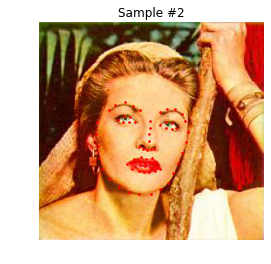

3 (1532, 1024, 3) (68, 2)


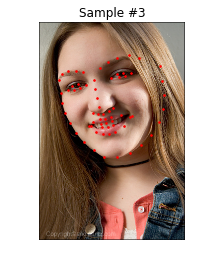

In [62]:
for i in range(len(face_dataset)):
    fig = plt.figure()
    sample = face_dataset[i]
    sample = resize(sample)
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    #ax = plt.subplot(4, 1, i+1)
    #plt.tight_layout()
    plt.title('Sample #{}'.format(i))
    plt.axis('off')
    show_landmarks(**sample)
    plt.show()
    if i == 3:
        #plt.show()
        break